In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shroomdk import ShroomDK
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PowerTransformer

In [2]:
#Setting up shroomDK powered by Flipside

sdk = ShroomDK(key)

In [3]:
def create_sql_list(df,col):
    df_new = ""
    inputs = list(df[col])
    i = 0
    for row in inputs:
        if i < len(inputs) - 1:
            df_new = df_new + "lower('" + row + "'),"
        else:
            df_new = df_new + "lower('" + row + "')"
        i += 1
    df_new = df_new + ""
    return df_new   

In [4]:
import math
def find_airdropers():
    sql = f"""
        with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
        block_timestamp as bt,
        to_address as airdrop_recipient,
        contract_address as token,
        amount
        FROM ethereum.core.ez_token_transfers
        WHERE contract_address = lower('0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC')
        and from_address = lower('0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC')
        ),

        first_30 as (
        SELECT *  FROM (SELECT --distinct(user_address)
        ROW_NUMBER() OVER (PARTITION BY user_address ORDER BY bt) as "Row",
        DATEDIFF(day, bt, block_timestamp) as "Time to Drop",
        user_address,
        1 as "Dumped 30",
        CASE WHEN prev_bal - current_bal > 0 THEN prev_bal - current_bal ELSE 0 END as amount_dumped
        FROM ethereum.core.ez_balance_deltas
        INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address
        WHERE current_bal < 1
        and DATEDIFF(day, bt, block_timestamp) < 30) temp WHERE "Row" = 1),


        now_time as (
          SELECT 
          user_address,
          block_timestamp as "Last Change",
          current_bal,
          "Date Since Airdrop",
          CURRENT_DATE - DATE(block_timestamp) as "Date Since Change"
            FROM (SELECT --distinct(user_address)
            ROW_NUMBER() OVER (PARTITION BY user_address ORDER BY block_timestamp DESC) as "Row",
            block_timestamp,
            DATEDIFF(day, bt, block_timestamp) as "Date Since Airdrop",
            user_address,
            current_bal,
            prev_bal
            FROM ethereum.core.ez_balance_deltas
            INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address) al
          WHERE "Row" = 1)


        SELECT 
            bt,
            airdrop_recipient,
            amount as amount_airdropped,
            "Time to Drop",
            amount_dumped,
            "Last Change",
            COALESCE("Dumped 30",0) as "Within 30",
            COALESCE(current_bal,amount) as current_balance,
            COALESCE(current_bal,amount) - amount as "net change"
        FROM airdrop_recipients a
        LEFT JOIN first_30 t ON airdrop_recipient = t.user_address
        LEFT JOIN now_time n ON airdrop_recipient = n.user_address
        ORDER BY COALESCE(current_bal,amount) - amount desc
        """
    query_result_set = sdk.query(sql)
    hoppers = pd.DataFrame(query_result_set.records)
    hoppers['Within 30'] = hoppers.apply(lambda x: 1 if x['within 30'] == 1  else 0,axis = 1)
    hoppers['Dumped All'] = hoppers.apply(lambda x: 1 if x['current_balance'] < 1 else 0,axis = 1)
    hoppers['Increased'] = hoppers.apply(lambda x: 1 if x['net change'] > 1 else 0,axis = 1)
    hoppers['HODL'] = hoppers.apply(lambda x: 1 if x['net change'] == 0 else 0,axis = 1)
    hoppers['No Dump'] = hoppers.apply(lambda x: 1 if x['net change'] >= 0 else 0,axis = 1)
    return hoppers 

In [6]:
#Hop Airdrop Info
from_address = '0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC'
contract_address = '0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC'
df_hop_airdrop = find_airdropers()
print(len(df_hop_airdrop))
print(len(df_hop_airdrop['airdrop_recipient'].unique()))

25484
25484


In [67]:
print(df_hop_airdrop.groupby('Within 30')['airdrop_recipient'].count())

Within 30
0    21215
1     4269
Name: airdrop_recipient, dtype: int64


In [ ]:
print(df_hop_airdrop.groupby('Dumped All')['airdrop_recipient'].count())

In [ ]:
print(df_hop_airdrop.groupby('Increased')['airdrop_recipient'].count())

In [ ]:
print(df_hop_airdrop.groupby('HODL')['airdrop_recipient'].count())

In [ ]:
#ETH Bridge Info
def get_bridge_info():
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as hop_address,
    contract_address as token,
    amount
    FROM ethereum.core.ez_token_transfers
    WHERE contract_address = lower('0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC')
    and from_address = lower('0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC')
    ),

    VOLUME_BRIDGED_TO_L2S AS (
     SELECT
    origin_from_address as address,
    COUNT(DISTINCT(tx_hash)) as no_bridges,
    CURRENT_DATE - MIN(DATE(block_timestamp))as earliest_time,
    CURRENT_DATE - MAX(DATE(block_timestamp)) as latest_time,
    COUNT(DISTINCT(symbol)) as no_tokens,
    SUM(amount_usd) as volume,
    AVG(amount_usd) as avg_volume_alt,
    stddev(amount_usd) as std_volume_alt
    FROM ethereum.core.ez_token_transfers 
    INNER JOIN airdrop_recipients ON hop_address = origin_from_address
    WHERE origin_to_address IN ('0x22b1cbb8d98a01a3b71d034bb899775a76eb1cc2', '0x3d4cc8a61c7528fd86c55cfe061a78dcba48edd1',
    '0x3666f603cc164936c1b87e207f36beba4ac5f18a','0x3e4a3a4796d16c0cd582c382691998f7c06420b6', '0xb98454270065a31d71bf635f6f7ee6a518dfb849')
    AND origin_function_signature = '0xdeace8f5' AND has_price = true  AND block_timestamp::date < '2022-04-01'
    GROUP BY origin_from_address
    ),


    VOLUME_BRIDGED_TO_ETH AS (SELECT
    origin_from_address as address,
    COUNT(DISTINCT(tx_hash)) as no_bridges,
    CURRENT_DATE - MIN(DATE(block_timestamp))as earliest_time,
    CURRENT_DATE - MAX(DATE(block_timestamp)) as latest_time,
    1 as no_tokens,
    SUM(amount_usd) as volume,
    AVG(amount_usd) as avg_volume_eth,
    stddev(amount_usd) as std_volume_eth
    FROM ethereum.core.ez_eth_transfers
    INNER JOIN airdrop_recipients ON hop_address = origin_from_address
    WHERE origin_to_address = '0xb8901acb165ed027e32754e0ffe830802919727f' AND origin_function_signature = '0xdeace8f5' 
      AND block_timestamp::date < '2022-04-01'
      GROUP BY origin_from_address
    )


    SELECT 
    COALESCE(l.address,e.address) as address,
    COALESCE(l.no_tokens,0) + COALESCE(e.no_tokens,0) as no_tokens,
    COALESCE(l.no_bridges,0) + COALESCE(e.no_bridges,0) as no_brides,
    COALESCE(l.volume,0) + COALESCE(e.volume,0) as volume,
    avg_volume_eth,
    std_volume_eth
    avg_volume_alt,
    std_volume_alt,
    CASE WHEN COALESCE(e.earliest_time,0) > COALESCE(l.earliest_time,0) THEN e.earliest_time ELSE l.earliest_time END as earliest_time,
    CASE WHEN COALESCE(e.latest_time,900000) < COALESCE(l.latest_time,900000) THEN e.latest_time ELSE l.latest_time END as latest_time
    FROM VOLUME_BRIDGED_TO_L2S l
    FULL OUTER JOIN VOLUME_BRIDGED_TO_ETH e ON l.address = e.address
    """
    query_result_set = sdk.query(sql)

    owner = pd.DataFrame(query_result_set.records)
    return owner

# Adress Info

In [ ]:
def get_address_info():
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as hop_address,
    contract_address as token,
    amount
    FROM ethereum.core.ez_token_transfers
    WHERE contract_address = lower('0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC')
    and from_address = lower('0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC')
    ),

    
    addy as (SELECT
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON hop_address = origin_from_address
    AND block_timestamp::date < '2022-04-01'

    UNION ALL

    SELECT 
    tx_hash,
    EVENT_NAME,
    origin_to_address as address,
    block_timestamp,
    origin_from_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON hop_address = origin_from_address
    AND block_timestamp::date < '2022-04-01'
    ),
    
    from_add as (
    SELECT 
    address,
      COUNT(DISTINCT(f.tx_hash)) as no_owner_tx_from,
      COUNT(DISTINCT(f.interact)) as unique_addresses_interact_from,
      CURRENT_DATE -  MIN(DATE(f.block_timestamp)) as days_since_first_tx_from,
      CURRENT_DATE -  MAX(DATE(f.block_timestamp)) as days_since_last_tx_from
    FROM (SELECT
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON hop_address = origin_from_address
    AND block_timestamp::date < '2022-04-01') f
     GROUP BY address),

    to_add as (
    SELECT 
    address,
  COUNT(DISTINCT(f.tx_hash)) as no_owner_tx_to,
  COUNT(DISTINCT(f.interact)) as unique_addresses_interact_to,
  CURRENT_DATE -  MIN(DATE(f.block_timestamp)) as days_since_first_tx_to,
  CURRENT_DATE -  MAX(DATE(f.block_timestamp)) as days_since_last_tx_to
    FROM (SELECT
    tx_hash,
    EVENT_NAME,
    origin_to_address as address,
    block_timestamp,
    origin_from_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON hop_address = origin_from_address
    AND block_timestamp::date < '2022-04-01') f
     GROUP BY address),



    temp as (SELECT 
      a.address,
      CURRENT_DATE -  MIN(DATE(a.block_timestamp)) as days_since_first_tx,
      CURRENT_DATE -  MAX(DATE(a.block_timestamp)) as days_since_last_tx,
       MAX(DATE(a.block_timestamp)) - MIN(DATE(a.block_timestamp)) as activity_span,
      COUNT(DISTINCT(a.tx_hash)) as no_owner_tx,
      COUNT(DISTINCT(a.contract_address)) as no_contracts,
      COUNT(DISTINCT(a.EVENT_NAME)) as no_events,
      COUNT(DISTINCT(a.interact)) as unique_addresses_interact 
    FROM addy a
    GROUP BY a.address) 
    
    
    SELECT 
    a.address,
    days_since_first_tx,
    days_since_last_tx,
    activity_span,
    no_owner_tx,
    no_contracts,
    no_events,
    unique_addresses_interact,
    no_owner_tx_from,
    unique_addresses_interact_from,
    days_since_first_tx_from,
    days_since_last_tx_from,
    no_owner_tx_to,
    unique_addresses_interact_to,
    days_since_first_tx_to,
    days_since_last_tx_to,
    no_owner_tx_from / no_owner_tx  as percent_from_tx,
    unique_addresses_interact_from / unique_addresses_interact  as unique_addresses_interact_from_percent,
    days_since_last_tx_from - days_since_last_tx_to as days_since_last_diff
    FROM temp a
    LEFT JOIN to_add t ON  t.address = a.address
    LEFT JOIN from_add f ON f.address = a.address
    """
    query_result_set = sdk.query(sql)

    owner = pd.DataFrame(query_result_set.records)
    return owner

In [ ]:
# max_number =round(len(df_hop_airdrop) / 1000)
i = 0
df_bridge = pd.DataFrame()
df_address = pd.DataFrame()
# while i < max_number:
#     first= i*1000
#     second= 1000 + i*1000
#     if first % 10000 == 0:
#         print (f"{i / max_number } % Complete")
#     string =create_sql_list(df_hop_airdrop[first:second],'airdrop_recipient')
    #querying data and concentating
bridge = get_bridge_info()
address = get_address_info()
df_bridge = pd.concat([df_bridge, bridge])
df_address = pd.concat([df_address,address])
i += 1

In [ ]:
df_address[df_address['address']=='0x35e3564c86bc0b5548a3be3a9a1e71eb1455fad2']

In [ ]:
#Airdrop Info

token = ['LOOKs','ENS','SOS','1INCH','Ribbon',
         'AMP','X2Y2',
         'EULER','BEND','UNI','DYDX']

from_address = ['0xA35dce3e0E6ceb67a30b8D7f4aEe721C949B5970',
                '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                #'0x5a5ecd062083733c9aa27cb4c5f113c42f730261',
                '0x0000000000000000000000000000000000000000',
                '0xe295ad71242373c37c5fda7b57f26f9ea1088afe',
                '0x7902e4bfb1eb9F4559d55417Aee1Dc6E4b8cC1Bf',
                '0xF497b83CfBd31E7Ba1Ab646F3B50aE0aF52d03A1',
                '0xe6949137b24ad50cce2cf6b124b3b874449a41fa',
                #'0xcAfE001067cDEF266AfB7Eb5A286dCFD277f3dE5',
                '0xd524e29e3baf5bb085403ca5665301e94387a7e2',
                '0x1b5d2904be3e4711a848be09b17dee89e6a5bc27',
                '0x090d4613473dee047c3f2706764f49e0821d256e',
                '0x639192d54431f8c816368d3fb4107bc168d0e871'
                
                
                ]
contract_address = ['0xf4d2888d29d722226fafa5d9b24f9164c092421e',
                   '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                   '0x3b484b82567a09e2588a13d54d032153f0c0aee0',
                   '0x111111111117dc0aa78b770fa6a738034120c302',
                   '0x6123b0049f904d730db3c36a31167d9d4121fa6b',
                    '0x77fba179c79de5b7653f68b5039af940ada60ce0',
                    '0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9',
                    #'0x090E53c44E8a9b6B1bcA800e881455b921AEC420',
                    '0xd9Fcd98c322942075A5C3860693e9f4f03AAE07b',
                    '0x0d02755a5700414b26ff040e1de35d337df56218',
                    '0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984',
                    '0x92D6C1e31e14520e676a687F0a93788B716BEff5'
                   ]

df_airdrops = pd.DataFrame({
    'Token':token,
    'From Address':from_address,
    'Contract Address': contract_address
})



In [ ]:
#functions query airdropers that have dumped a particular token in less than a week of a holding (wallet balence = 0)
def find_airdroppers(token,address,contract,airdropper_df):
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as airdrop_recipient,
    contract_address as token
    FROM ethereum.core.fact_token_transfers
    WHERE contract_address = lower('{contract}')
    and from_address = lower('{address}')
    )

    SELECT --distinct(user_address)
    ROW_NUMBER() OVER (PARTITION BY user_address ORDER BY bt) as "Row",
    DATEDIFF(day, bt, block_timestamp) as "Time to Drop",
    user_address as airdrop_recipient,
    prev_bal as amount_dumped
    FROM ethereum.core.ez_balance_deltas
    INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address
    WHERE current_bal = 0
    and DATEDIFF(day, bt, block_timestamp) < 30
    """

    query_result_set = sdk.query(sql)
    
    dumpers = pd.DataFrame(query_result_set.records)
    dumpers = dumpers[dumpers["row"] == 1]
    dumpers.columns = [str(col) + '_' + token if col != 'user_address' else col for col in dumpers.columns]

    no_dumpers = len(dumpers)
    print(f'Identifed {no_dumpers} that dumped {token} within a month')
    
    col_name = 'Dumped ' + token
    row_name = 'row_' + token
    dumpers[col_name] = 1
#     print(dumpers.head())
    ids = 'airdrop_recipient' + '_' + token
    airdropper_df = pd.merge(airdropper_df,dumpers,left_on='airdrop_recipient',right_on= ids,how='left')
    airdropper_df = airdropper_df.drop(columns=[ids,row_name])
    no_addresses = airdropper_df.loc[airdropper_df[col_name] == 1,'airdrop_recipient'].unique()
    airdropper_df = airdropper_df.fillna(0)
    
    airdropper_df['Number of Airdrops Dumped'] = airdropper_df['Number of Airdrops Dumped'] + airdropper_df[col_name]
    airdropper_df['Tokens Dumped'] = np.where(airdropper_df[col_name] == 1, airdropper_df['Tokens Dumped'] +", "+ col_name, airdropper_df['Tokens Dumped'])
    
    print(f'Identifed {len(no_addresses)} owner addresses that dumped {token}')
    return airdropper_df, no_dumpers,len(no_addresses)
    

In [ ]:
i = 0
dumped = []
add = []
past_dump = df_hop_airdrop[['airdrop_recipient']].copy()
past_dump['Number of Airdrops Dumped'] = 0
past_dump['Tokens Dumped'] = ''
while i < len(df_airdrops):
    token = df_airdrops.loc[i,'Token']
    address = df_airdrops.loc[i,'From Address']
    contract = df_airdrops.loc[i,'Contract Address']
    past_dump, no_dumpers,no_addresses = find_airdroppers(token,address,contract,past_dump)
    dumped.append(no_dumpers)
    add.append(no_addresses)
    i += 1

In [ ]:
df_airdrops['# of Dumpers'] = dumped
df_airdrops['# of Addresses'] = add

In [ ]:
plt.figure()
plt.title('# of Addresses that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Dumpers")
plt.figure()
plt.title('# of Hop Airdroppers that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Addresses")
plt.figure()
plt.title('Histogram of Number of Aridrops previously dumped')
sns.histplot(x='Number of Airdrops Dumped',data=past_dump)

# ITS MERGING TIME

In [ ]:
past_dump.to_csv('PastDump.csv')
df_bridge.to_csv('Bridge.csv')
df_address.to_csv('Address.csv')
past_dump

In [13]:
past_dump = pd.read_csv('PastDump.csv')
df_bridge= pd.read_csv('Bridge.csv')
df_address= pd.read_csv('Address.csv')

In [14]:
df = df_hop_airdrop.copy()
df_bridge = df_bridge.drop_duplicates()
df = pd.merge(df, df_bridge,left_on='airdrop_recipient',right_on='address', how = 'left')
df = pd.merge(df, df_address,left_on='airdrop_recipient',right_on='address', how = 'left')
df = pd.merge(df, past_dump,on='airdrop_recipient',how = 'left')
df

,bt,airdrop_recipient,amount_airdropped,time to drop,amount_dumped,last change,within 30,current_balance,net change,Within 30,...,Dumped X2Y2,time to drop_EULER,amount_dumped_EULER,Dumped EULER,time to drop_BEND,amount_dumped_BEND,Dumped BEND,time to drop_UNI,amount_dumped_UNI,Dumped UNI
0,2022-06-10 08:46:06.000,0x4ffad6ac852c0af0aa301376f4c5dea3a928b120,1.083876e+04,NaN,NaN,2022-09-12 23:59:44.000,0,1.101657e+06,1.090818e+06,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2022-06-09 22:45:30.000,0x9f1920d0cbb63ed03376a1e09fd2851d601234c8,2.310148e+03,7.0,1701.555066,2022-09-19 23:59:59.000,1,5.217302e+05,5.194200e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.0,430.944126,1.0
2,2022-06-10 15:47:54.000,0xdd37d30f4f71ea88eb67e8bd5dbe831d288ff8fc,1.402949e+03,NaN,NaN,2022-09-20 23:59:59.000,0,4.000002e+05,3.985973e+05,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,2022-06-23 08:42:45.000,0x0fccef1c29deddb1e2a007ee9c1edf63149aa6b3,2.463171e+04,NaN,NaN,2022-08-19 23:58:27.000,0,3.859707e+05,3.613390e+05,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,349808.216656,1.0
4,2022-06-09 18:41:06.000,0x21f60de5e8875a9f39a705ea8b2deec13bbd14cc,4.308489e+03,NaN,NaN,2022-06-21 23:59:58.000,0,2.568624e+05,2.525539e+05,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25479,2022-07-08 12:33:56.000,0xf5f8ee3e4c7dbdc2639946cd92b21cffd4324652,1.438276e+05,25.0,143827.554703,2022-08-02 23:58:57.000,1,0.000000e+00,-1.438276e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25480,2022-06-09 19:43:59.000,0xcafb4ff79d39949d29e2ec4eb6b42c1e7b4d8b2b,1.470991e+05,0.0,0.000000,2022-08-03 23:59:53.000,1,0.000000e+00,-1.470991e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25481,2022-06-10 00:36:55.000,0x07c2af75788814ba7e5225b2f5c951ed161cb589,1.868631e+05,1.0,366651.173931,2022-06-11 23:59:29.000,1,0.000000e+00,-1.868631e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25482,2022-06-10 10:14:17.000,0x7c132bde28ad1e0101d45121757d7c6c2e8a550a,2.249185e+05,0.0,0.000000,2022-07-10 23:59:56.000,1,0.000000e+00,-2.249185e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [15]:
df

,bt,airdrop_recipient,amount_airdropped,time to drop,amount_dumped,last change,within 30,current_balance,net change,Within 30,...,Dumped X2Y2,time to drop_EULER,amount_dumped_EULER,Dumped EULER,time to drop_BEND,amount_dumped_BEND,Dumped BEND,time to drop_UNI,amount_dumped_UNI,Dumped UNI
0,2022-06-10 08:46:06.000,0x4ffad6ac852c0af0aa301376f4c5dea3a928b120,1.083876e+04,NaN,NaN,2022-09-12 23:59:44.000,0,1.101657e+06,1.090818e+06,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2022-06-09 22:45:30.000,0x9f1920d0cbb63ed03376a1e09fd2851d601234c8,2.310148e+03,7.0,1701.555066,2022-09-19 23:59:59.000,1,5.217302e+05,5.194200e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.0,430.944126,1.0
2,2022-06-10 15:47:54.000,0xdd37d30f4f71ea88eb67e8bd5dbe831d288ff8fc,1.402949e+03,NaN,NaN,2022-09-20 23:59:59.000,0,4.000002e+05,3.985973e+05,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,2022-06-23 08:42:45.000,0x0fccef1c29deddb1e2a007ee9c1edf63149aa6b3,2.463171e+04,NaN,NaN,2022-08-19 23:58:27.000,0,3.859707e+05,3.613390e+05,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,349808.216656,1.0
4,2022-06-09 18:41:06.000,0x21f60de5e8875a9f39a705ea8b2deec13bbd14cc,4.308489e+03,NaN,NaN,2022-06-21 23:59:58.000,0,2.568624e+05,2.525539e+05,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25479,2022-07-08 12:33:56.000,0xf5f8ee3e4c7dbdc2639946cd92b21cffd4324652,1.438276e+05,25.0,143827.554703,2022-08-02 23:58:57.000,1,0.000000e+00,-1.438276e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25480,2022-06-09 19:43:59.000,0xcafb4ff79d39949d29e2ec4eb6b42c1e7b4d8b2b,1.470991e+05,0.0,0.000000,2022-08-03 23:59:53.000,1,0.000000e+00,-1.470991e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25481,2022-06-10 00:36:55.000,0x07c2af75788814ba7e5225b2f5c951ed161cb589,1.868631e+05,1.0,366651.173931,2022-06-11 23:59:29.000,1,0.000000e+00,-1.868631e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25482,2022-06-10 10:14:17.000,0x7c132bde28ad1e0101d45121757d7c6c2e8a550a,2.249185e+05,0.0,0.000000,2022-07-10 23:59:56.000,1,0.000000e+00,-2.249185e+05,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [16]:
# for column in df.columns:
#     print(column)

df['Time Between Hop and Wallet'] = df['days_since_first_tx'] - df['earliest_time']
df['hop_time_span'] = df['earliest_time'] - df['latest_time']
df['Frequency of Use'] = df['no_brides'] / (df['hop_time_span'] + 1)
df['Dumped Token'] = df['Number of Airdrops Dumped'].apply(lambda x: 1 if x > 0 else 0)
df['% bridge'] = df['no_brides'] / df['no_owner_tx']


X = df.copy()
X = X.drop(columns = ['bt','airdrop_recipient',
                      'amount_airdropped','time to drop',
                     'amount_dumped','last change','current_balance',
                     'net change','Within 30','Dumped All','Increased',
                     'No Dump','address_x','HODL','address_y','Tokens Dumped','within 30'])

y = df[['amount_airdropped','time to drop',
                     'amount_dumped','last change','current_balance',
                     'net change','Within 30','Dumped All','Increased',
                     'No Dump','address_x']]

In [17]:
X = X.fillna(0)
X

,Unnamed: 0_x,no_tokens,no_brides,volume,avg_volume_eth,avg_volume_alt,std_volume_alt,earliest_time,latest_time,Unnamed: 0_y,...,amount_dumped_BEND,Dumped BEND,time to drop_UNI,amount_dumped_UNI,Dumped UNI,Time Between Hop and Wallet,hop_time_span,Frequency of Use,Dumped Token,% bridge
0,5644.0,3.0,25.0,5.994401e+05,24319.934762,9900.001175,14644.421068,360.0,182.0,48788.0,...,0.0,0.0,0.0,0.000000,0.0,367.0,178.0,0.139665,1,0.026911
1,3769.0,2.0,2.0,1.957042e+05,186244.670000,0.000000,0.000000,342.0,266.0,9394.0,...,0.0,0.0,3.0,430.944126,1.0,884.0,76.0,0.025974,1,0.006667
2,5110.0,3.0,5.0,6.406670e+05,165.960000,0.000000,71225.684445,179.0,176.0,17519.0,...,0.0,0.0,0.0,0.000000,0.0,198.0,3.0,1.250000,0,0.172414
3,8804.0,1.0,1.0,1.999566e+05,0.000000,0.000000,0.000000,222.0,222.0,13786.0,...,0.0,0.0,29.0,349808.216656,1.0,1058.0,0.0,1.000000,1,0.005814
4,9485.0,1.0,1.0,2.999548e+04,0.000000,0.000000,0.000000,268.0,268.0,42850.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25479,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,34763.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0,0.000000
25480,9850.0,1.0,1.0,5.120257e+04,0.000000,0.000000,0.000000,360.0,360.0,1152.0,...,0.0,0.0,0.0,0.000000,0.0,1048.0,0.0,1.000000,0,0.014706
25481,1827.0,1.0,2.0,1.650226e+06,825113.150000,0.000000,0.000000,338.0,338.0,3180.0,...,0.0,0.0,0.0,0.000000,0.0,522.0,0.0,2.000000,1,0.001360
25482,4685.0,3.0,11.0,2.396163e+06,238729.355000,153502.460973,58925.654694,322.0,260.0,60402.0,...,0.0,0.0,0.0,0.000000,0.0,379.0,62.0,0.174603,0,0.002699


In [18]:
log_cols = ['no_owner_tx',
            'unique_addresses_interact',
            'no_contracts',
           'days_since_first_tx',
            'days_since_last_tx',
           'avg_volume_eth', 
            'no_owner_tx_to',
            'no_owner_tx_from',
            'volume']
scale_cols = [x for x in X.columns if x not in log_cols]
scale_pipe = make_pipeline(MinMaxScaler())
log_pipe = make_pipeline(PowerTransformer())

transformer = ColumnTransformer(remainder='passthrough',
    transformers=[
        ("scale", scale_pipe, scale_cols),
        ("log_transform", log_pipe, log_cols),
    ]
)

X = X.reset_index(drop = True)
scaled = transformer.fit_transform(X)  

X = pd.DataFrame(scaled, index=X.index, columns=X.columns)


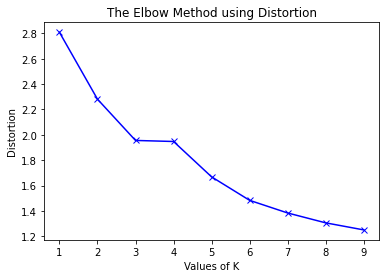

In [19]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [20]:
km = KMeans(n_clusters=4)
km.fit(X)
label = km.labels_
df['Cluster'] = label

In [21]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X)
res = pd.DataFrame(pca.transform(X))

In [22]:
pca1 = abs(pca.components_[0])
pca2 = abs(pca.components_[1])
k = 10
pca1_index = np.argpartition(pca1, len(pca1) - k)[-k:]
pca2_index = np.argpartition(pca2, len(pca2) - k)[-k:]

In [23]:
pca1_most_important = X.columns[pca1_index]
pca2_most_important = X.columns[pca2_index]
print("Most Important Features for X: " + str(pca1_most_important))
print("Most Important Features for Y: " + str(pca2_most_important))

Most Important Features for X: Index(['avg_volume_alt', 'time to drop_BEND', 'hop_time_span',
       'Time Between Hop and Wallet', '% bridge', 'Dumped UNI',
       'time to drop_UNI', 'Dumped BEND', 'Dumped Token', 'amount_dumped_UNI'],
      dtype='object')
Most Important Features for Y: Index(['Dumped BEND', 'amount_dumped_UNI', 'time to drop_UNI', 'Unnamed: 0_x',
       'Dumped UNI', 'Time Between Hop and Wallet', 'hop_time_span',
       'std_volume_alt', 'avg_volume_alt', '% bridge'],
      dtype='object')


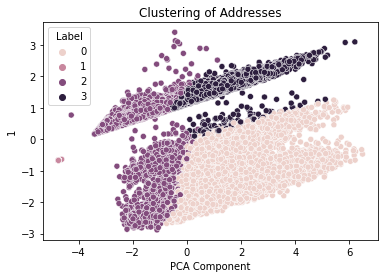

In [24]:
res['Label'] = label
plt.figure()
plt.title('Clustering of Addresses')
sns.scatterplot(x =0,y =1,hue ='Label',data = res)
plt.xlabel('PCA Component')
X['Label'] = label
df['Label'] = label

In [25]:
df.groupby(['Within 30'])['airdrop_recipient'].count()

Within 30
0    21215
1     4269
Name: airdrop_recipient, dtype: int64

In [27]:
df.groupby(['Label','Within 30'])['airdrop_recipient'].count()

Label  Within 30
0      0            7423
       1            1653
1      0            1554
       1             345
2      0            7184
       1            1301
3      0            5054
       1             970
Name: airdrop_recipient, dtype: int64

Supervised learning

In [28]:
from sklearn.model_selection import train_test_split
y2 = y['Within 30']
X_train,X_test,y_train,y_test = train_test_split(X,y2,test_size = .3, random_state = 42)

In [ ]:
df_address

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, model_selection
from sklearn.svm import SVC
import xgboost as xgboost


lr = LogisticRegression()
rf = RandomForestClassifier()
svc = SVC(random_state=0,probability=False)
xgb = xgboost.XGBClassifier()


svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

# calculate auc
print(f"SVC AUC: {metrics.roc_auc_score(y_test, y_pred_svc)}")
print(f"RF AUC: {metrics.roc_auc_score(y_test, y_pred_rf)}")
print(f"LR AUC: {metrics.roc_auc_score(y_test, y_pred_lr)}")
print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_xgb)}")

C:\Users\jackl\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SVC AUC: 0.575844610044162
RF AUC: 0.7221992660068117
LR AUC: 0.6863399615619675
XGB AUC: 0.7540919302542932


Oversampling

In [30]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X_train,y_train)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
xgb_o = xgboost.XGBClassifier()
xgb_o.fit(X_resampled, y_resampled)
y_pred_o = xgb_o.predict(X_test)

print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_o)}")

XGB AUC: 0.8591608927847828


In [31]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train,y_train)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
xgb_o = xgboost.XGBClassifier()
xgb_o.fit(X_resampled, y_resampled)
y_pred_o = xgb_o.predict(X_test)

print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_o)}")

XGB AUC: 0.8891429215206341


In [32]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
ros.fit(X_train,y_train)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_pred_rf_o = rf.predict(X_test)

print(f"RF AUC: {metrics.roc_auc_score(y_test, y_pred_rf_o)}")

RF AUC: 0.7914232187279107


In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
#elapsed_time = time.time() - start_time

#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
import pandas as pd
feature_names = [f"{i}" for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
df.groupby()

In [ ]:
forest_importances.sort_Values

In [ ]:
pip install imblearn

In [ ]:
import seaborn as sns

sns.histplot(x = 'days_since_last_tx',data=df,hue='Within 30',element='step',multiple='stack',bins =20)

In [ ]:
sns.histplot(x = 'Frequency of Use',data=df,hue='Within 30',element='step',multiple='stack',bins =20)

In [ ]:
# import shap

# explainer = shap.TreeExplainer(rf)

# shap_values = explainer.shap_values(X_test)

# # Make plot. Index of [1] is explained in text below.
# shap.summary_plot(shap_values[1], X_test)

In [ ]:
# for i in df.columns:
#     try:
#         plt.figure()
#         plt.title(f'Historgram by Cluster - {i}')
#         sns.histplot(x=i,data=df)
#     except: 
#         a= 1

<AxesSubplot:title={'center':'Did a Address that Dumped a previous airdrop Dump $Hop?'}, xlabel='Number of Airdrops Dumped', ylabel='Count'>

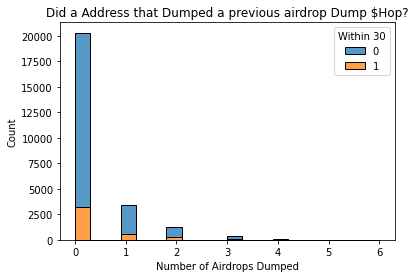

In [36]:
plt.figure()
plt.title('Did a Address that Dumped a previous airdrop Dump $Hop?')
sns.histplot(x = 'Number of Airdrops Dumped',data =df,hue = 'Within 30',element='step',multiple='stack',bins =20)

In [42]:
df.groupby(['Number of Airdrops Dumped','Within 30'])['airdrop_recipient'].count()

Number of Airdrops Dumped  Within 30
0.0                        0            17083
                           1             3237
1.0                        0             2793
                           1              618
2.0                        0              983
                           1              283
3.0                        0              278
                           1              107
4.0                        0               66
                           1               20
5.0                        0               10
                           1                4
6.0                        0                2
Name: airdrop_recipient, dtype: int64

In [66]:
tt = df[df['no_owner_tx'].isna()]
tt

,bt,airdrop_recipient,amount_airdropped,time to drop,amount_dumped,last change,within 30,current_balance,net change,Within 30,...,time to drop_UNI,amount_dumped_UNI,Dumped UNI,Time Between Hop and Wallet,hop_time_span,Frequency of Use,Dumped Token,% bridge,Cluster,Label
44,2022-06-11 18:24:41.000,0x6aff94e478d8fd5b61111b2045ca77079b23fd8a,1000.000000,NaN,NaN,2022-06-17 23:59:33.000,0,1.724993e+04,16249.932943,0,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
63,2022-06-10 01:34:08.000,0x2069b403927ae71db075fa1c7af0541d70af61e1,1000.000000,NaN,NaN,2022-08-21 23:59:20.000,0,1.011893e+04,9118.926746,0,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
85,2022-06-09 18:59:55.000,0x4e1700bd150e07027fe5a2dbad5942fa4d238056,2971.207541,2.0,5000.000000,2022-08-03 23:59:53.000,1,9.779726e+03,6808.518820,1,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
101,2022-07-02 19:44:32.000,0x23ee374e2d80a11ff433d8c496641bd96a30ff27,113.828487,NaN,NaN,2022-07-02 23:59:46.000,0,5.380452e+03,5266.623513,0,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
111,2022-06-11 07:10:36.000,0x2059a2fd10bbe557db5fc562c0d7e3769677bc80,1317.865166,NaN,NaN,2022-08-24 23:59:22.000,0,5.843005e+03,4525.140000,0,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25000,2022-06-09 19:08:21.000,0x60b0fba5b289800743b35ad8be16cddede2bd67f,2069.464103,4.0,2069.464103,2022-06-13 23:59:42.000,1,0.000000e+00,-2069.464103,1,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
25211,2022-06-12 11:38:14.000,0xcc679d3d8c73a23c2bbef55b86b4fedcab601acb,3360.480034,NaN,NaN,2022-07-29 23:59:44.000,0,0.000000e+00,-3360.480034,0,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
25267,2022-07-11 03:32:32.000,0x116ceb3d8d258e2a97a1f05c901ef508809f55ec,3791.275409,27.0,3791.275409,2022-08-07 23:59:57.000,1,0.000000e+00,-3791.275409,1,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
25355,2022-06-10 06:58:33.000,0x7e7461d8a79780193aba6dbba6cfe6ba137cd64a,7000.000000,2.0,7000.000000,2022-06-12 23:59:43.000,1,0.000000e+00,-7000.000000,1,...,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,1,1
